In [1]:
import torch
import torch.nn as nn
from transformers import (
    SamVisionConfig,
    SamPromptEncoderConfig,
    SamMaskDecoderConfig,
    SamModel,
    SamProcessor,
    SamImageProcessor
)
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from PIL import Image
import json
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from transformers import SamModel, SamConfig

In [2]:
class HyperspectralExpandedDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Root directory containing the expanded dataset.
        """
        self.root_dir = root_dir
        self.samples = self._load_samples()

    def _load_samples(self):
        """
        Scans the directory structure to find all saved samples.

        Returns:
            list: List of dictionaries containing file paths for each sample.
        """
        samples = []
        for sample_name in os.listdir(self.root_dir):
            sample_path = os.path.join(self.root_dir, sample_name)
            if not os.path.isdir(sample_path):
                continue

            # Collect file paths for bands, binary mask, and prompt
            bands_path = os.path.join(sample_path, "bands.pt")
            mask_path = os.path.join(sample_path, "binary_mask.tif")
            prompt_path = os.path.join(sample_path, "prompt.json")

            if os.path.exists(bands_path) and os.path.exists(mask_path) and os.path.exists(prompt_path):
                samples.append({
                    "bands": bands_path,
                    "mask": mask_path,
                    "prompt": prompt_path
                })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Loads a sample.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (prompt, bands, binary_mask)
        """
        sample = self.samples[idx]

        bands = None
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.load.*")
            bands = torch.load(sample["bands"])

        binary_mask = to_tensor(Image.open(sample["mask"])).squeeze(0)  # Remove channel dimension

        with open(sample["prompt"], "r") as f:
            prompt = json.load(f)

        return prompt, bands, binary_mask


In [3]:
root_dir = "./expanded_dataset_output"
dataset = HyperspectralExpandedDataset(root_dir=root_dir)

# Split dataset: 90% training, 10% evaluation
train_size = int(0.9 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# DataLoaders
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

In [4]:
class HyperspectralSAM(nn.Module):
    def __init__(self, sam_checkpoint="facebook/sam-vit-base", num_input_channels=12):
        """
        Adapt SAM for hyperspectral data by modifying the input layer to handle more channels
        and adding a final layer for binary segmentation.

        Args:
            sam_checkpoint (str): Hugging Face SAM model checkpoint.
            num_input_channels (int): Number of input channels for hyperspectral data.
        """
        super(HyperspectralSAM, self).__init__()

        vision_config = SamVisionConfig(num_channels=12, image_size=120)
        decoder_config = SamMaskDecoderConfig(num_multimask_outputs = 1)
        prompt_config  = SamPromptEncoderConfig(image_size=120)
        
        config = SamConfig(vision_config = vision_config, 
                           prompt_encoder_config = prompt_config, 
                           mask_decoder_config = decoder_config, 
                           name_or_path=sam_checkpoint
                          )

        
        # self.processor = SamProcessor(img_processor)
        self.sam_model = SamModel.from_pretrained(sam_checkpoint, config=config, ignore_mismatched_sizes=True)
        self.sam_model.train()
    def forward(self, pixel_values, input_points=None):
        """
        Forward pass for the adapted SAM model.

        Args:
            pixel_values (torch.Tensor): Input tensor of shape (batch_size, num_channels, height, width).
            input_points (torch.Tensor, optional): Points as input prompts, of shape (batch_size, num_points, 2).
            input_boxes (torch.Tensor, optional): Boxes as input prompts, of shape (batch_size, num_boxes, 4).
            input_masks (torch.Tensor, optional): Masks as input prompts, of shape (batch_size, height, width).

        Returns:
            torch.Tensor: Binary segmentation logits of shape (batch_size, 1, height, width).
        """

        outputs = self.sam_model(
            pixel_values=pixel_values,
            input_points=input_points
        )
        return outputs
        # outputs["iou_scores"]
        # logits = self.final_conv(outputs["pred_masks"][:, 0, :, :, :])
        # return {"pred_masks": logits}


In [5]:
def normalize_per_image(img):
    """
    Normalize an image tensor by dividing each pixel value by the maximum value in the image (plus 1).

    Args:
        img (torch.Tensor): Image tensor of shape (batch_size, channels, height, width).

    Returns:
        torch.Tensor: Normalized image tensor with values in the range [0, 1].
    """
    # Compute the maximum value per image
    max_val = img.amax(dim=(-1, -2), keepdim=True)  # Max value per channel
    max_val = max_val + 1  # Add 1 to avoid division by zero

    # Normalize by max value
    normalized_img = img / max_val
    return normalized_img


In [6]:
def calculate_iou(pred_mask, actual_mask):
    """
    Calculate the Intersection over Union (IoU) between the predicted mask and the actual mask.

    Args:
        pred_mask (torch.Tensor): Predicted binary mask of shape (batch_size, height, width).
        actual_mask (torch.Tensor): Actual binary mask of shape (batch_size, height, width).

    Returns:
        torch.Tensor: IoU for each sample in the batch.
    """
    # Ensure shapes match
    assert pred_mask.shape == actual_mask.shape, "Shape mismatch between pred_mask and actual_mask"
    
    # Flatten the masks for IoU calculation
    pred_mask = pred_mask.view(pred_mask.size(0), -1)  # (batch_size, height * width)
    actual_mask = actual_mask.view(actual_mask.size(0), -1)  # (batch_size, height * width)

    # Calculate intersection and union
    intersection = (pred_mask * actual_mask).sum(dim=1)  # Sum over pixels for each sample
    union = (pred_mask + actual_mask).clamp(0, 1).sum(dim=1)  # Union over pixels for each sample

    # Avoid division by zero by adding a small epsilon
    iou = intersection / (union + 1e-6)

    return iou


In [7]:
import os
from torchvision.transforms import Resize, Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt

def eval_model(eval_loader, experiment_name, criterion, device, visualize_samples=5, epoch=10):
    # criterion = nn.BCEWithLogitsLoss()
    checkpoint_path = f"models/{experiment_name}hyperspectral_sam_epoch_{epoch}.pt"
    model = torch.load(checkpoint_path, map_location=device)
    model = model.to(device)
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_iou = 0.0
    samples_visualized = 0
    total_samples = 0

    progress_bar = enumerate(eval_loader)

    for batch_idx, (prompt, img, mask) in progress_bar:
        if "1024" in experiment_name:
            resize_img = Resize(1024, antialias=True)
            # Preprocess the image
            img = normalize_per_image(resize_img(img))  # Normalize input images
        else:
            img = normalize_per_image(img)
        img = img.to(device)  # Move to the correct device
        mask = mask.to(device)  # Preprocess the mask
        
        # Preprocess input points
        random_point_x, random_point_y = prompt['random_point']
        random_point = torch.stack((random_point_x, random_point_y), dim=-1).to(device)  # Combine and move to device
        random_point = random_point.unsqueeze(1).unsqueeze(2).to(device)  # Shape: (batch_size, 1, 1, 2)
        

        with torch.no_grad():
            # Forward pass
            
            predictions = model(pixel_values=img, input_points=random_point)

            # Resize mask to match the predictions' spatial dimensions
            predictions_shape = predictions["pred_masks"].shape[-2:]  # (height, width)
            resize_mask = Resize(predictions_shape, antialias=True)  # Dynamically adjust mask size
            mask_resized = resize_mask(mask).unsqueeze(1)
            
            # Threshold predictions to binary masks
            pred_binary_mask = (torch.sigmoid(predictions["pred_masks"]) > 0.5).squeeze(1).float()
            # print(pred_binary_mask.shape, mask_resized.shape, predictions["pred_masks"].shape) 
            # Calculate loss
            loss = criterion(predictions["pred_masks"].squeeze(1), mask_resized.float())
            total_loss += loss.item()
            # print(pred_binary_mask.max(), predictions["pred_masks"].min(), predictions["pred_masks"].max())
            # Calculate IoU
            iou = calculate_iou(pred_binary_mask, mask_resized)
            total_iou += iou.sum().item()
            total_samples += iou.size(0)

            # progress_bar.set_postfix(loss=loss.item(), avg_iou=iou.mean().item())

            # Visualize some samples
            if samples_visualized < visualize_samples:
                visualize_evaluation(img, pred_binary_mask * 255, mask_resized, batch_idx, experiment_name)
                samples_visualized += 1

    # Average loss and IoU over all batches
    avg_loss = total_loss / len(eval_loader)
    avg_iou = total_iou / total_samples

    print(f"Evaluation completed. Average Loss: {avg_loss}, Average IoU: {avg_iou}")
    return avg_loss, avg_iou


def visualize_evaluation(img, pred_mask, actual_mask, batch_idx, experiment):
    """
    Visualizes the first image in each batch.

    Args:
        img (torch.Tensor): Input image tensor of shape (batch_size, 12, height, width).
        pred_mask (torch.Tensor): Predicted mask tensor of shape (batch_size, 1, height, width).
        actual_mask (torch.Tensor): Actual mask tensor of shape (batch_size, height, width).
        batch_idx (int): Batch index for labeling the visualization.
    """
    # Focus only on the first image in the batch
    rgb_image = img[0, 1:4].permute(1, 2, 0).cpu().numpy()  # Extract RGB channels and convert to (H, W, C)
    pred = pred_mask[0].permute(1, 2, 0).cpu().numpy()  # Extract the first predicted mask
    actual = actual_mask[0].permute(1, 2, 0).cpu().numpy()  # Extract the first actual mask

    # print(rgb_image.shape, pred.shape, actual.shape)
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Batch {batch_idx}, First Sample")
    
    # RGB Image
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title("RGB Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred, cmap="jet")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Actual Mask
    plt.subplot(1, 3, 3)
    plt.imshow(actual, cmap="jet")
    plt.title("Actual Mask")
    plt.axis("off")
    save_dir = f"results/{batch_idx}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{experiment[:-1]}.png")
    plt.show()

In [8]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super(DiceLoss, self).__init__()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        # Apply sigmoid to logits with clamping for stability
        probs = torch.sigmoid(logits).clamp(min=1e-6, max=1-1e-6)

        # Flatten tensors for Dice and BCE calculations
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        # Dice loss with epsilon to avoid division by zero
        intersection = (probs_flat * targets_flat).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection / (probs_flat.sum(dim=1) + targets_flat.sum(dim=1) + 1e-6)).mean()

        # Combine BCE and Dice loss
        total_loss = dice_loss

        # Validate loss for NaN
        if not torch.isfinite(total_loss):
            print("NaN detected in loss computation")
            print(f"Logits: {logits}")
            print(f"Targets: {targets}")
            print(f"Probs: {probs}")
            print(f"BCE Loss: {bce_loss}, Dice Loss: {dice_loss}")
            raise ValueError("Loss computation resulted in NaN")

        return total_loss


In [9]:
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.7):
        super(DiceBCELoss, self).__init__()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        # Apply sigmoid to logits with clamping for stability
        probs = torch.sigmoid(logits).clamp(min=1e-6, max=1-1e-6)

        # Flatten tensors for Dice and BCE calculations
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        # Weighted BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        weight = torch.ones_like(targets) * 0.38  # Background weight
        weight[targets == 1] = 1.0  # Foreground weight
        bce_loss = (bce_loss * weight).mean()

        # Dice loss with epsilon to avoid division by zero
        intersection = (probs_flat * targets_flat).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection / (probs_flat.sum(dim=1) + targets_flat.sum(dim=1) + 1e-6)).mean()

        # Combine BCE and Dice loss
        total_loss = self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

        # Validate loss for NaN
        if not torch.isfinite(total_loss):
            print("NaN detected in loss computation")
            print(f"Logits: {logits}")
            print(f"Targets: {targets}")
            print(f"Probs: {probs}")
            print(f"BCE Loss: {bce_loss}, Dice Loss: {dice_loss}")
            raise ValueError("Loss computation resulted in NaN")

        return total_loss


In [10]:
EXPERIMENT_LIST = iter([
    ("centroid_bce/", 9, nn.BCEWithLogitsLoss()),
    ("random_bce/", 9, nn.BCEWithLogitsLoss()),
    ("random_prompt/", 50, DiceBCELoss()),
    ("centroid_prompt/", 50, DiceBCELoss()),
    ("centroid_prompt_dice_only/", 50, DiceLoss()),
    ("centroid_prompt_1024/", 50, DiceBCELoss()),
    
])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

======================centroid_bce/============================


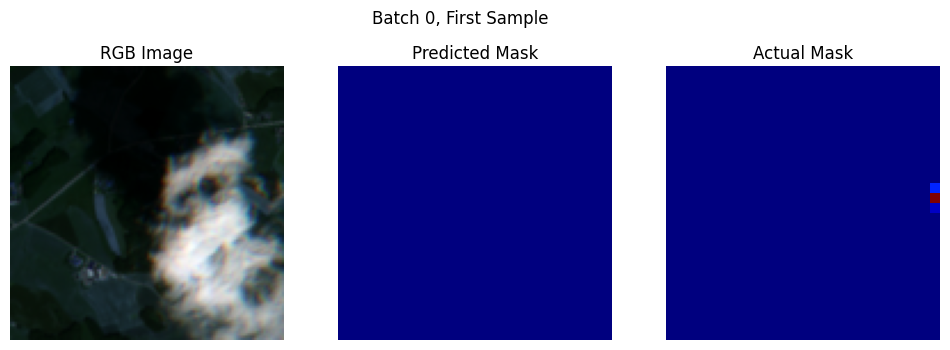

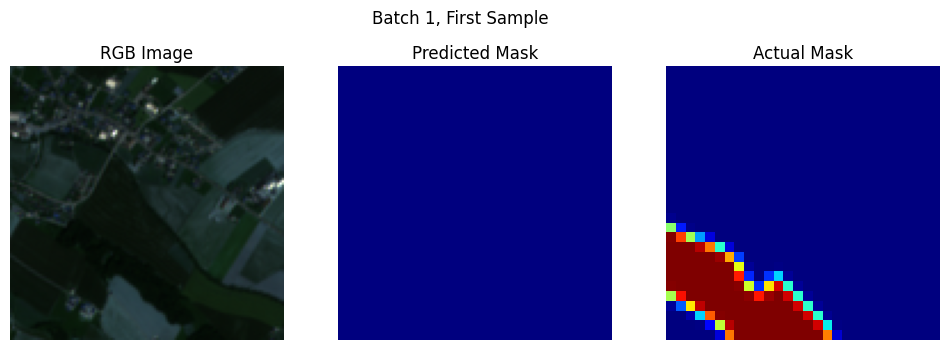

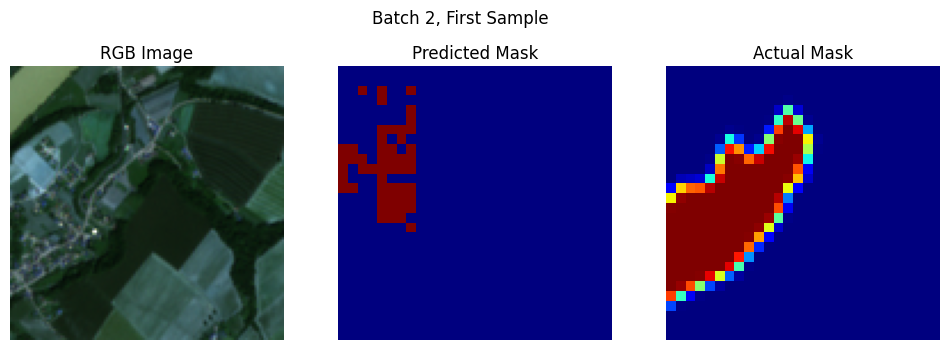

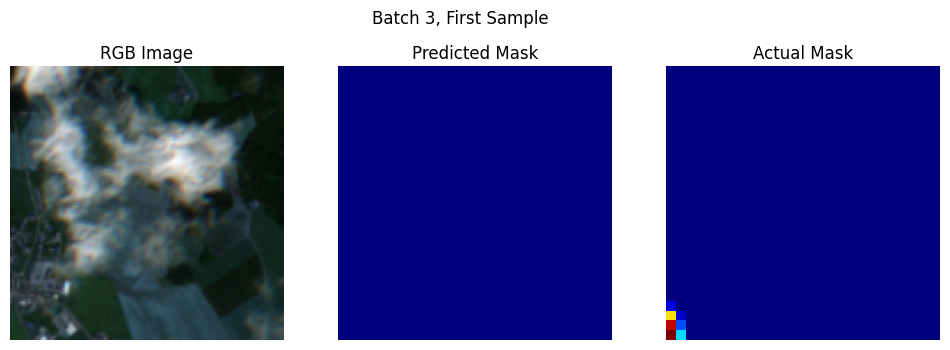

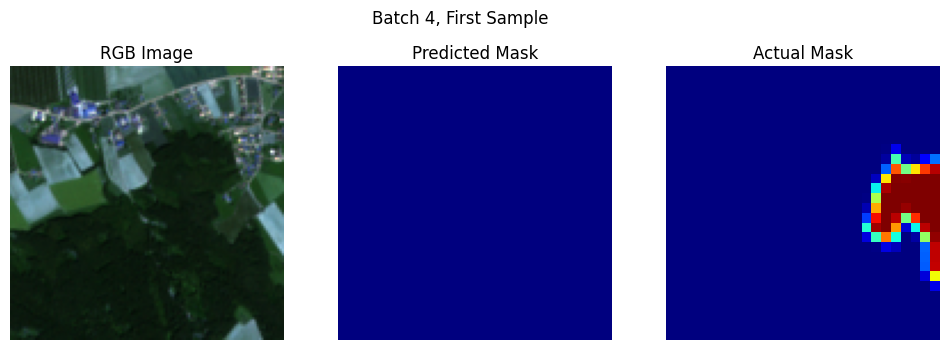

Evaluation completed. Average Loss: 0.3601810159090864, Average IoU: 0.025488939054389686
Results for centroid_bce/ are: (0.3601810159090864, 0.025488939054389686)
======================random_bce/============================


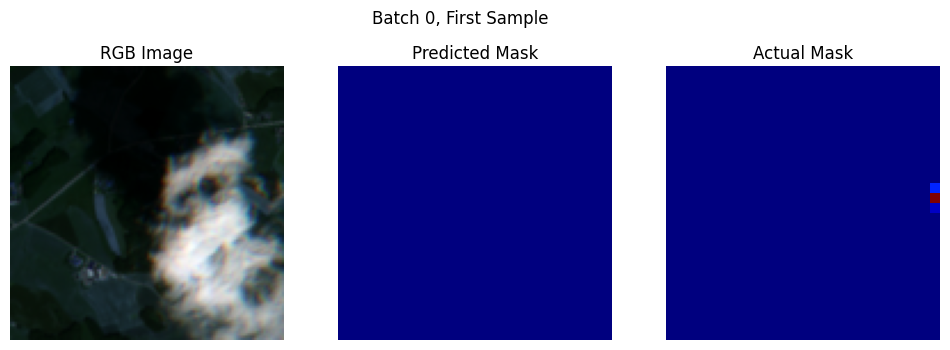

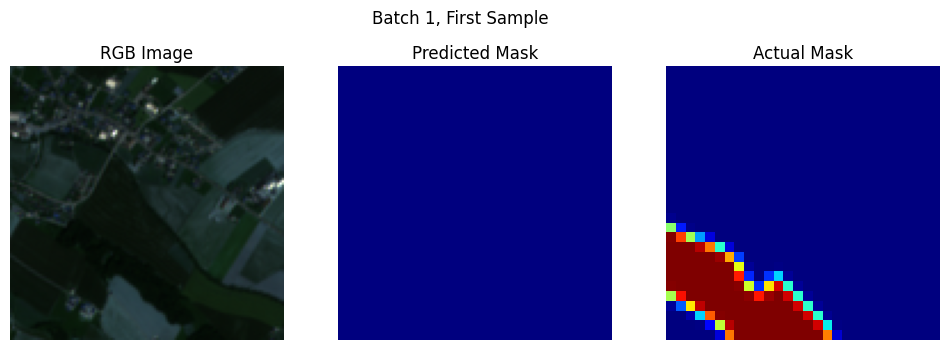

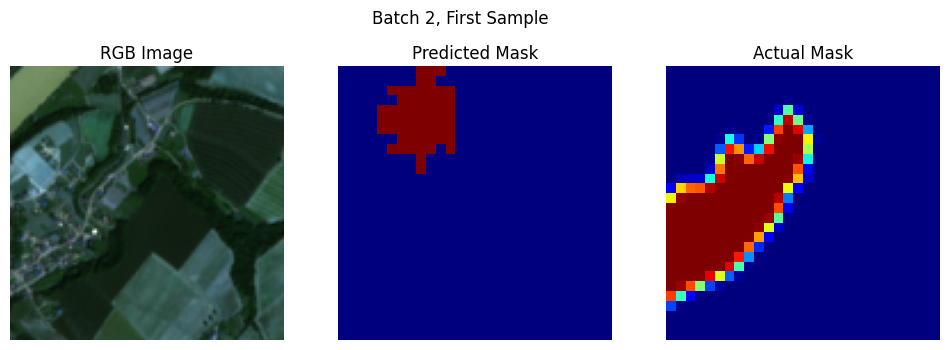

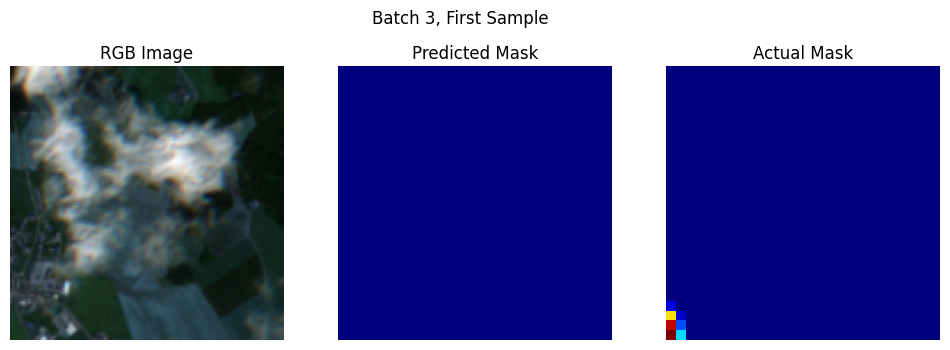

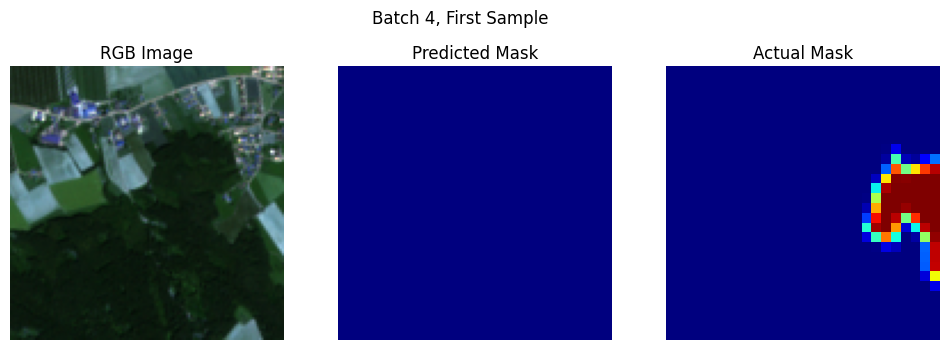

Evaluation completed. Average Loss: 0.34773232610081767, Average IoU: 0.02903016875080079
Results for random_bce/ are: (0.34773232610081767, 0.02903016875080079)
======================random_prompt/============================


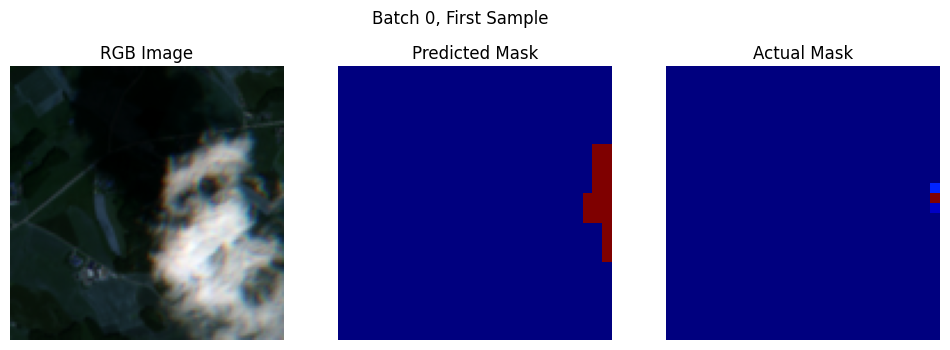

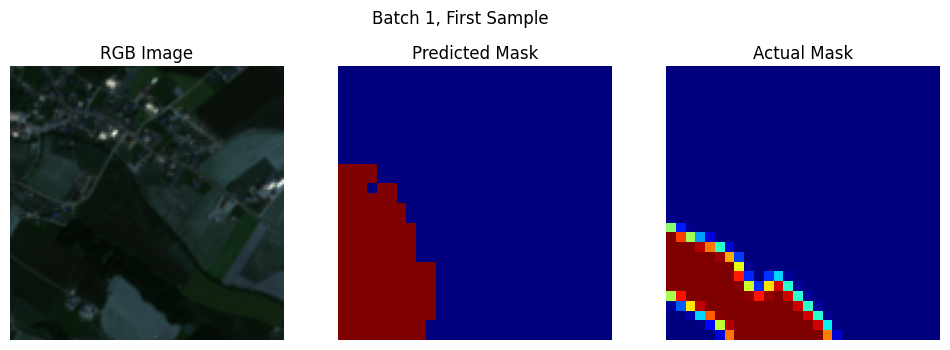

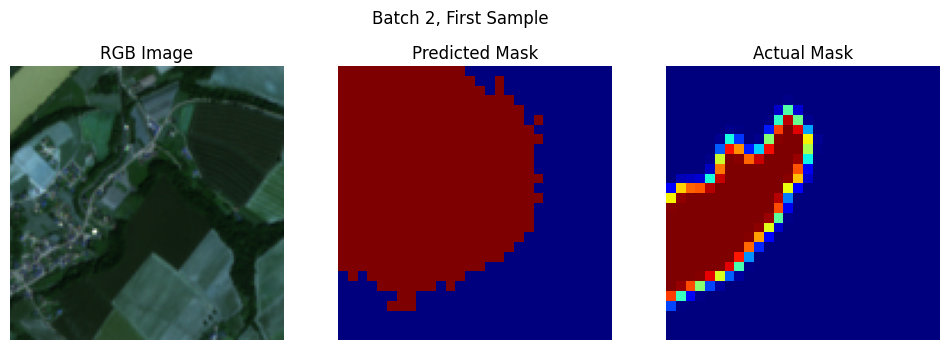

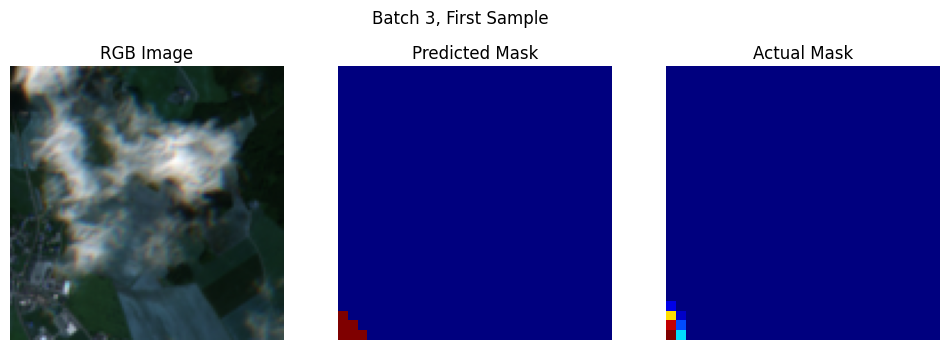

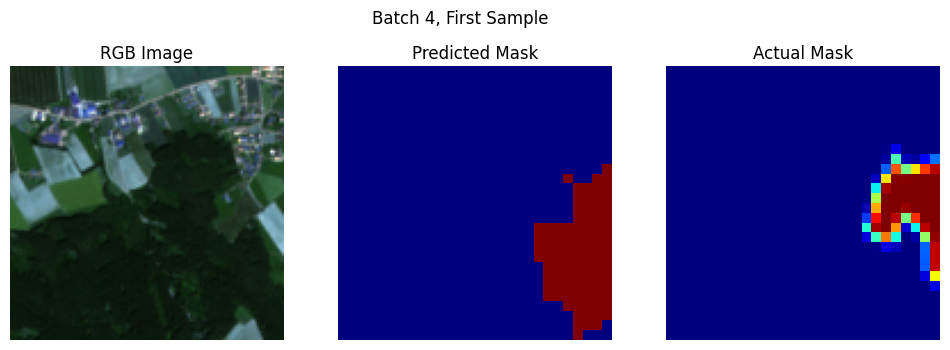

Evaluation completed. Average Loss: 0.3223129356202064, Average IoU: 0.28469484351880203
Results for random_prompt/ are: (0.3223129356202064, 0.28469484351880203)
======================centroid_prompt/============================


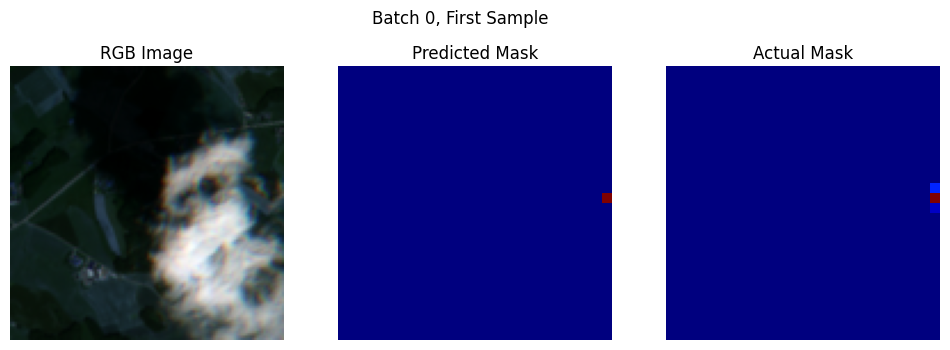

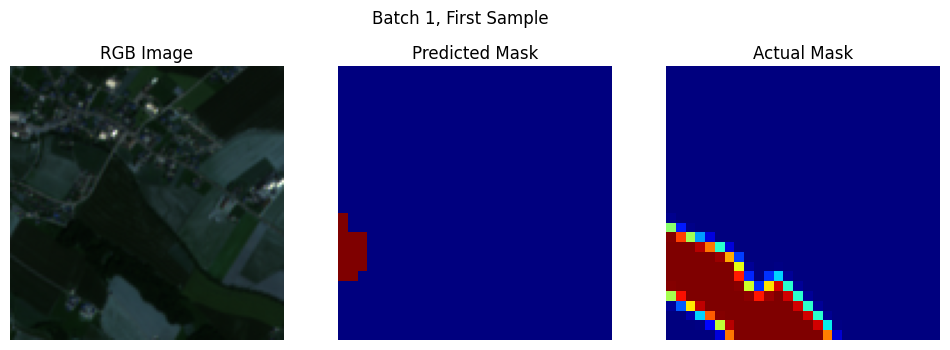

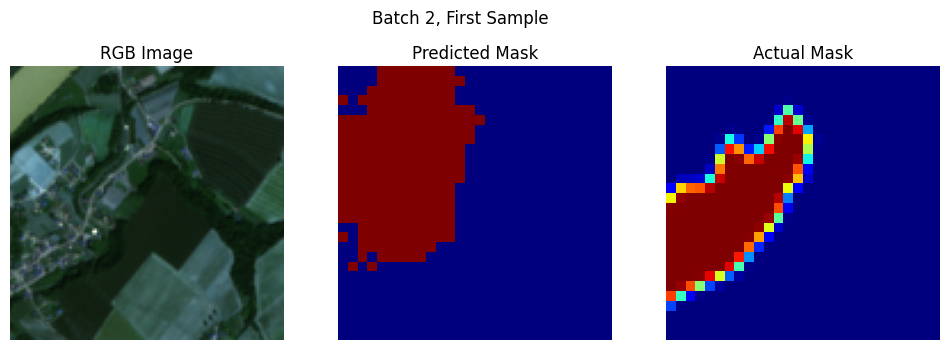

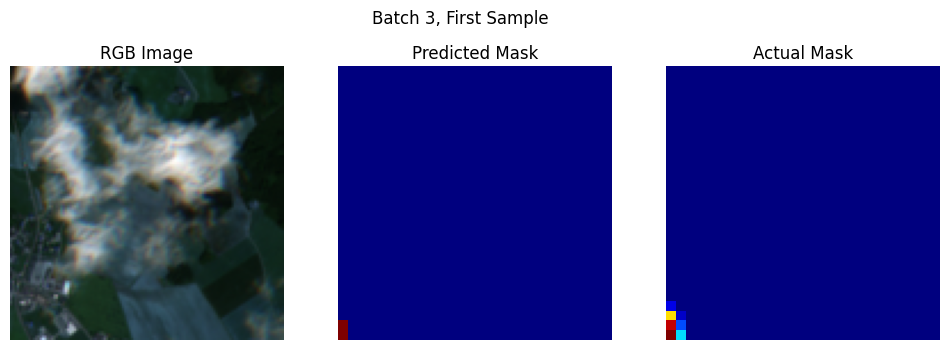

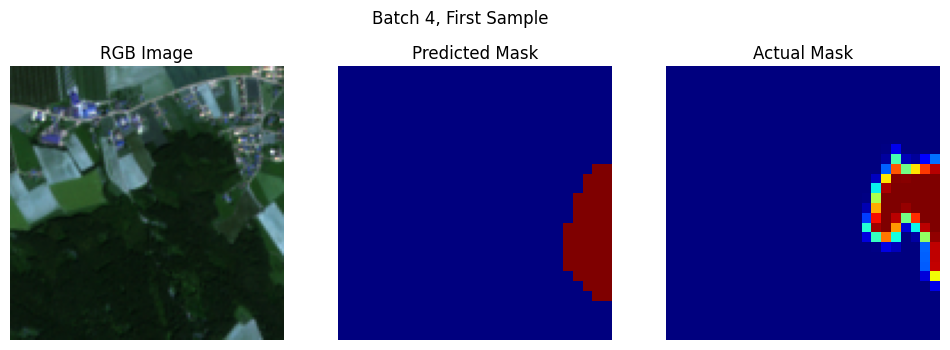

Evaluation completed. Average Loss: 0.5991001818116627, Average IoU: 0.2667221345823102
Results for centroid_prompt/ are: (0.5991001818116627, 0.2667221345823102)
======================centroid_prompt_dice_only/============================


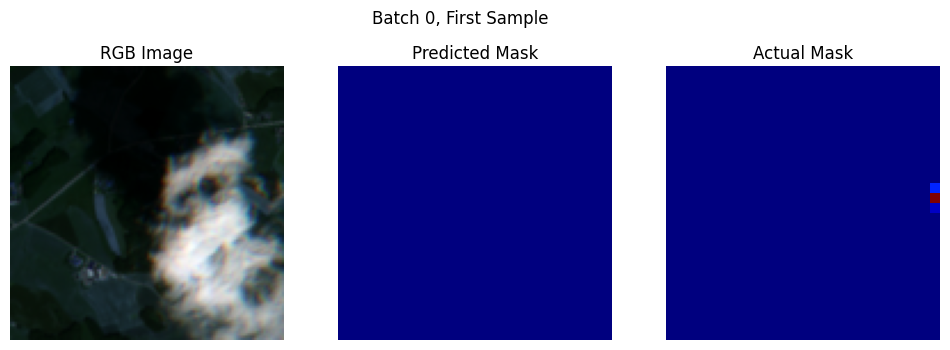

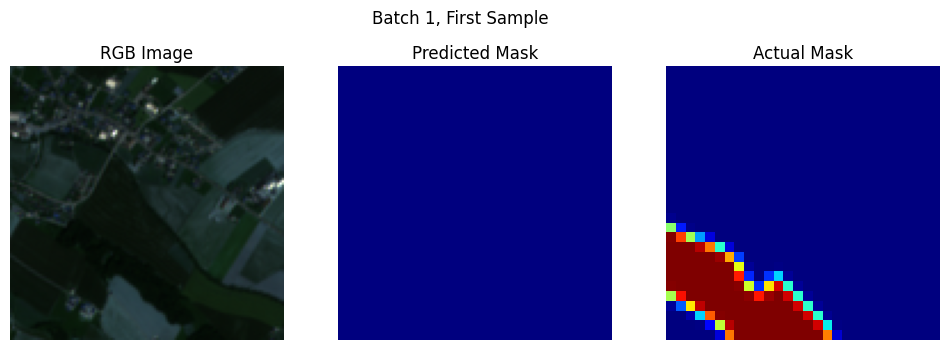

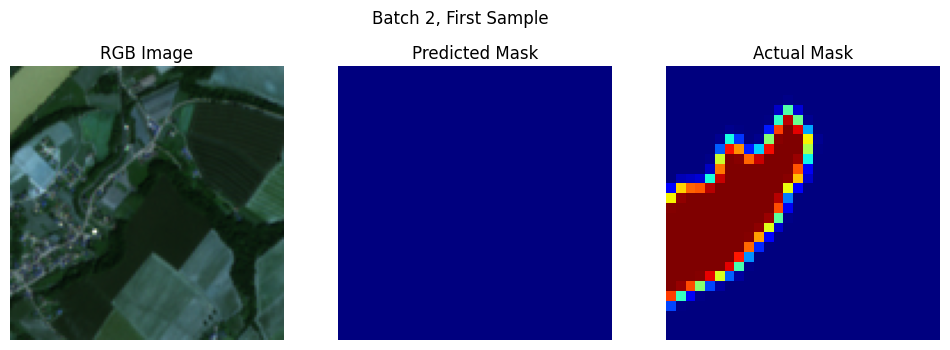

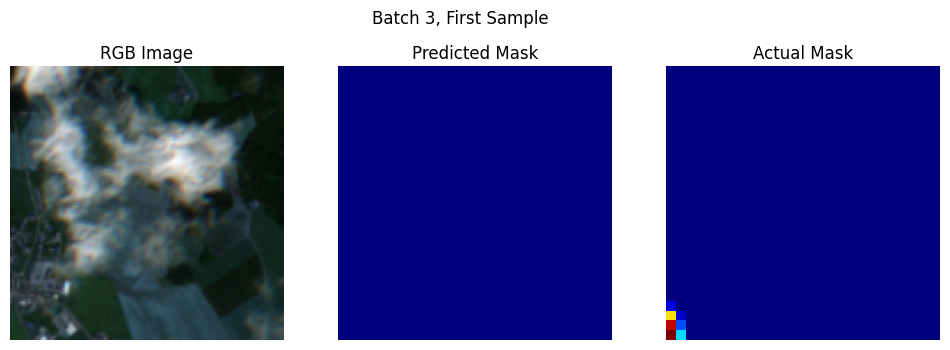

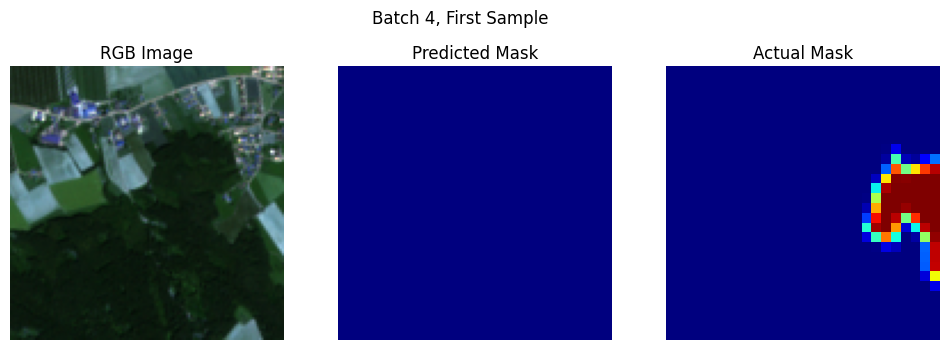

Evaluation completed. Average Loss: 0.7804433132305798, Average IoU: 0.149088648311372
Results for centroid_prompt_dice_only/ are: (0.7804433132305798, 0.149088648311372)
======================centroid_prompt_1024/============================


FileNotFoundError: [Errno 2] No such file or directory: 'models/centroid_prompt_1024/hyperspectral_sam_epoch_50.pt'

In [12]:
for experiment_name, epoch, loss in EXPERIMENT_LIST:
    print(f"======================{experiment_name}============================")
    avg_loss = eval_model(eval_loader, experiment_name, loss,device, visualize_samples=5, epoch=epoch)
    print(f"Results for {experiment_name} are: {avg_loss}")
    print(f"======================================================")

In [13]:
EXPERIMENT_LIST = iter([
    ("centroid_prompt_1024/", 9, DiceBCELoss()),
])

======================centroid_prompt_1024/============================


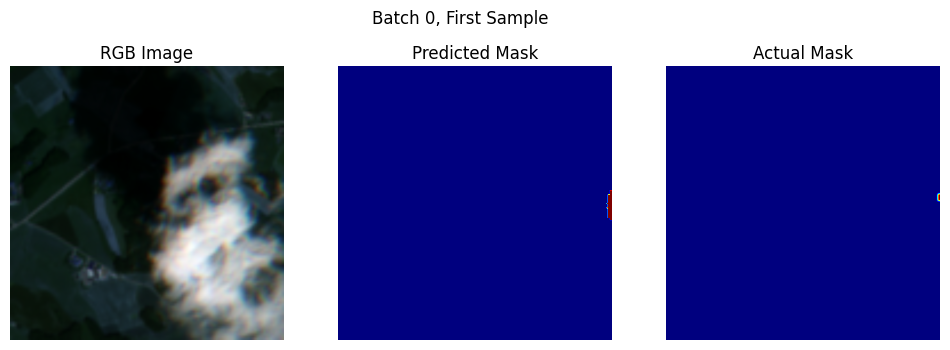

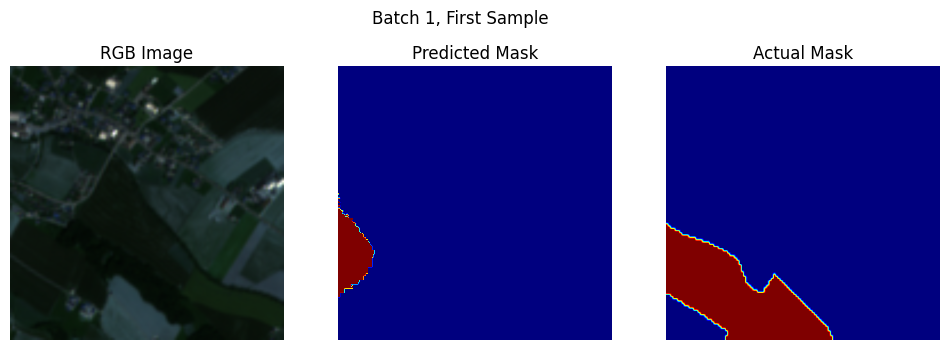

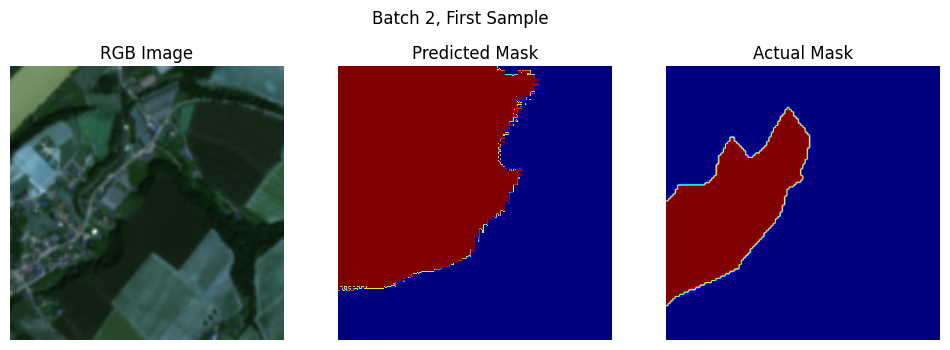

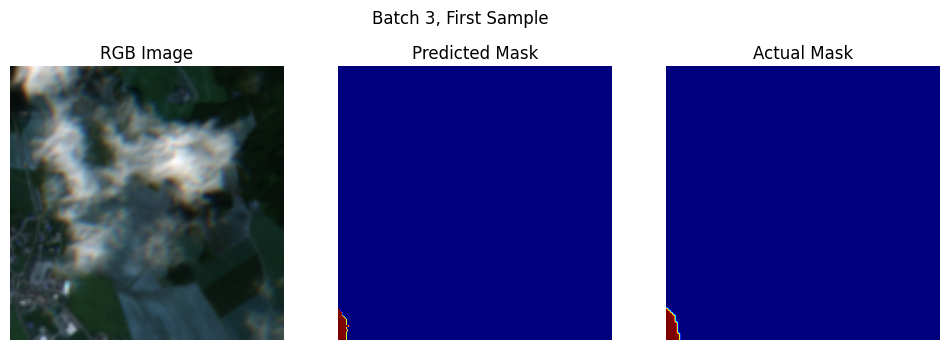

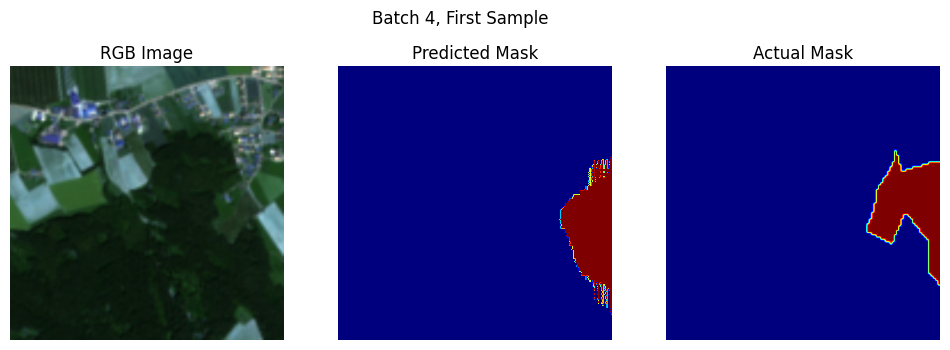

Evaluation completed. Average Loss: 0.6524496661647871, Average IoU: 0.29048826830456304
Results for centroid_prompt_1024/ are: (0.6524496661647871, 0.29048826830456304)


In [14]:
for experiment_name, epoch, loss in EXPERIMENT_LIST:
    print(f"======================{experiment_name}============================")
    avg_loss = eval_model(eval_loader, experiment_name, loss,device, visualize_samples=5, epoch=epoch)
    print(f"Results for {experiment_name} are: {avg_loss}")
    print(f"======================================================")